Hypothesis: We might be representation bottlenecked and that might be contributing to our less than ideal performance. What if we start by pretraining our network to do autoencoding, chop off the decoder, and then do our metric learning on that

In [1]:
import transformer_lens
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import numpy as np

import torch.nn.functional as F

from tqdm import tqdm

import random

In [2]:
seed = 42
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [3]:
# Load datasets
train_set = load_dataset("sentence-transformers/stsb", split="train")
val_set   = load_dataset("sentence-transformers/stsb", split="validation")
test_set  = load_dataset("sentence-transformers/stsb", split="test")

first_train  = torch.load('qwen2_05b_hook_resid_post_train_acts_1.npy')
second_train = torch.load('qwen2_05b_hook_resid_post_train_acts_2.npy')

first_test = torch.load('qwen2_05b_hook_resid_post_test_acts_1.npy')
second_test = torch.load('qwen2_05b_hook_resid_post_test_acts_2.npy')

wikitext_acts = torch.load('qwen2_20k_11162024.npy')

train_scores = torch.Tensor(train_set['score'])
test_scores = torch.Tensor(test_set['score'])

In [4]:
first_train.shape, second_train.shape, first_test.shape, second_test.shape, wikitext_acts.shape

(torch.Size([5749, 24, 896]),
 torch.Size([5749, 24, 896]),
 torch.Size([1379, 24, 896]),
 torch.Size([1379, 24, 896]),
 torch.Size([20000, 24, 896]))

 10%|███████                                                                | 10/100 [02:04<18:35, 12.39s/it]


Epoch 10
Train Losses - Early: 0.004, Mid: 0.015, Late: 0.131
Test Losses  - Early: 0.026, Mid: 0.071, Late: 0.423


 20%|██████████████▏                                                        | 20/100 [04:04<15:48, 11.86s/it]


Epoch 20
Train Losses - Early: 0.004, Mid: 0.013, Late: 0.112
Test Losses  - Early: 0.023, Mid: 0.064, Late: 0.380


 30%|█████████████████████▎                                                 | 30/100 [06:02<13:48, 11.83s/it]


Epoch 30
Train Losses - Early: 0.003, Mid: 0.013, Late: 0.104
Test Losses  - Early: 0.022, Mid: 0.062, Late: 0.362


 40%|████████████████████████████▍                                          | 40/100 [08:00<11:48, 11.81s/it]


Epoch 40
Train Losses - Early: 0.003, Mid: 0.012, Late: 0.100
Test Losses  - Early: 0.022, Mid: 0.060, Late: 0.347


 50%|███████████████████████████████████▌                                   | 50/100 [09:58<09:50, 11.81s/it]


Epoch 50
Train Losses - Early: 0.003, Mid: 0.012, Late: 0.097
Test Losses  - Early: 0.021, Mid: 0.060, Late: 0.343


 60%|██████████████████████████████████████████▌                            | 60/100 [11:56<07:51, 11.78s/it]


Epoch 60
Train Losses - Early: 0.003, Mid: 0.012, Late: 0.095
Test Losses  - Early: 0.021, Mid: 0.059, Late: 0.339


 70%|█████████████████████████████████████████████████▋                     | 70/100 [13:53<05:53, 11.77s/it]


Epoch 70
Train Losses - Early: 0.003, Mid: 0.011, Late: 0.094
Test Losses  - Early: 0.021, Mid: 0.059, Late: 0.335


 80%|████████████████████████████████████████████████████████▊              | 80/100 [15:51<03:55, 11.78s/it]


Epoch 80
Train Losses - Early: 0.003, Mid: 0.011, Late: 0.092
Test Losses  - Early: 0.021, Mid: 0.059, Late: 0.335


 90%|███████████████████████████████████████████████████████████████▉       | 90/100 [17:48<01:57, 11.77s/it]


Epoch 90
Train Losses - Early: 0.003, Mid: 0.011, Late: 0.091
Test Losses  - Early: 0.021, Mid: 0.058, Late: 0.330


100%|██████████████████████████████████████████████████████████████████████| 100/100 [19:45<00:00, 11.85s/it]


Epoch 100
Train Losses - Early: 0.003, Mid: 0.011, Late: 0.091
Test Losses  - Early: 0.021, Mid: 0.058, Late: 0.329


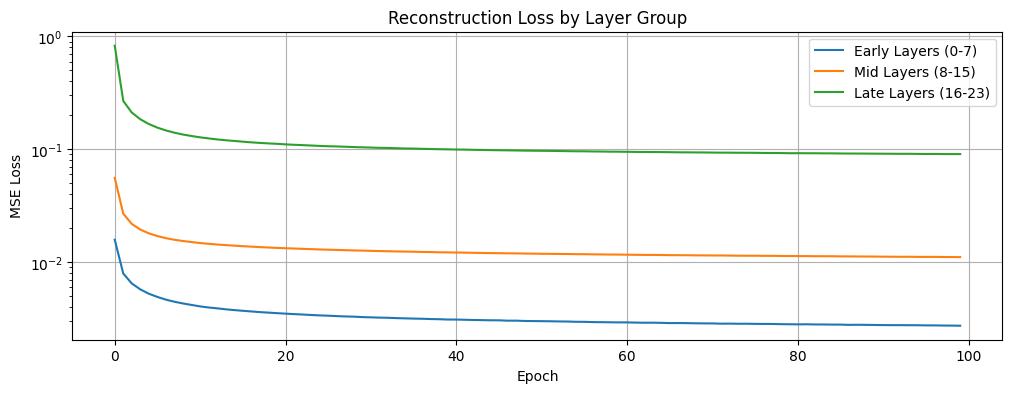

In [5]:
# We probably need to scale the hidden dimension based on how deep you are
def get_hidden(i):
    if i < 12:
        return 1
    else:
        return 2

class Autoencoder(nn.Module):
    def __init__(self, layer_idx, d_in=896, base_width=256, dropout_rate=0.1):
        super().__init__()
        # Scale hidden dim based on layer position
        # Later layers get progressively larger capacity
        hidden_mult = get_hidden(layer_idx)
        d_hidden = int(base_width * hidden_mult)
        
        # Gradual dimension reduction
        d_mid = (d_in + d_hidden) // 2
        
        self.encode = nn.Sequential(
            nn.Linear(d_in, d_mid),
            nn.LayerNorm(d_mid),
            nn.Dropout(dropout_rate),  # After normalization, before activation
            nn.SiLU(),
            nn.Linear(d_mid, d_hidden),
            nn.LayerNorm(d_hidden),
            nn.Dropout(dropout_rate),  # After normalization, before activation
            nn.SiLU(),
        )
        
        self.decode = nn.Sequential(
            nn.Linear(d_hidden, d_mid),
            nn.LayerNorm(d_mid),
            nn.Dropout(dropout_rate),  # After normalization, before activation
            nn.SiLU(),
            nn.Linear(d_mid, d_in),
            # No dropout before final output layer
        )
        
        # Initialize with smaller weights for stability
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)
                
    def forward(self, x):
        h = self.encode(x)
        return self.decode(h)

n_layers = 24
# Create layer-specific autoencoders
encoders = [Autoencoder(i).cuda() for i in range(n_layers)]

# Use different learning rates for different layers
lrs = [3e-4 * (1 + i/24) for i in range(n_layers)]  # Higher lr for harder layers. From 3e-4 -> 3e-4*3
optimizers = [torch.optim.AdamW(ae.parameters(), lr=lr, weight_decay=0.01) for ae, lr in zip(encoders, lrs)]

# Modified training loop with layer-specific logging
def train_epoch(models, acts, optimizers, batch_size=64):
    indices = torch.randperm(acts.shape[0])
    shuffled_acts = acts[indices]
    
    losses = []
    n_batches = shuffled_acts.shape[0] // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        
        batch_losses = []
        for i, (model, optimizer) in enumerate(zip(models, optimizers)):
            model.train()
            batch_i = shuffled_acts[start_idx:end_idx, i].cuda()
            
            optimizer.zero_grad()
            loss = F.mse_loss(model(batch_i), batch_i)
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        losses.append(batch_losses)
    
    return np.mean(losses, axis=0)

# Training with more detailed monitoring
early_layers_history = []
mid_layers_history = []
late_layers_history = []

all_acts = wikitext_acts
all_test_acts = torch.concat((first_test, second_test), axis=0)

for epoch in tqdm(range(100)):
    losses = train_epoch(encoders, all_acts, optimizers)
    
    # Track different layer groups
    early_layers_history.append(np.mean(losses[:8]))
    mid_layers_history.append(np.mean(losses[8:16]))
    late_layers_history.append(np.mean(losses[16:]))
    
    if (epoch+1) % 10 == 0:
        with torch.no_grad():
            [model.eval() for model in encoders]
            
            # Test losses by layer group
            test_preds = [encoders[i](all_test_acts[:, i].cuda()).cpu() for i in range(n_layers)]
            test_losses = [F.mse_loss(pred, all_test_acts[:, i]).item() for i, pred in enumerate(test_preds)]
            
            print(f"\nEpoch {epoch+1}")
            print(f"Train Losses - Early: {early_layers_history[-1]:.3f}, "
                  f"Mid: {mid_layers_history[-1]:.3f}, "
                  f"Late: {late_layers_history[-1]:.3f}")
            print(f"Test Losses  - Early: {np.mean(test_losses[:8]):.3f}, "
                  f"Mid: {np.mean(test_losses[8:16]):.3f}, "
                  f"Late: {np.mean(test_losses[16:]):.3f}")

# Plot training curves
plt.figure(figsize=(12, 4))
plt.plot(early_layers_history, label='Early Layers (0-7)')
plt.plot(mid_layers_history, label='Mid Layers (8-15)')
plt.plot(late_layers_history, label='Late Layers (16-23)')
plt.title('Reconstruction Loss by Layer Group')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

In [6]:
class SiameseNetwork(nn.Module):
    def __init__(self, mlp):
        super().__init__()
        self.mlp = mlp

    def forward(self, x1, x2):
        h1 = self.mlp(x1)
        h2 = self.mlp(x2)
        return F.cosine_similarity(h1, h2, dim=-1)

class LayerwiseSiameseNetworks(nn.Module):
    def __init__(self, encoders, n_layers=24, d_in=1024, d_hidden=256):
        super().__init__()
        self.n_layers = n_layers
        self.layer_nets = nn.ModuleList([SiameseNetwork(encoders[i]) for i in range(n_layers)])

    def forward(self, x1, x2):
        similarities = []
        for layer in range(self.n_layers):
            net_at_layer = self.layer_nets[layer].cuda()
            # Get the activations at the given layer
            x1_l = x1[:, layer].cuda()
            x2_l = x2[:, layer].cuda()

            sim_at_layer = net_at_layer(x1_l, x2_l)
            # print(sim_at_layer.shape)
            similarities.append(sim_at_layer)

        return torch.stack(similarities, dim=-1)

class SimilarityLearner(nn.Module):
    def __init__(self, encoders, n_layers=24, d_in=1024, d_hidden=256, d_out_hidden=512, dropout=0.1):
        super().__init__()
        self.layer_nets = LayerwiseSiameseNetworks(encoders, n_layers, d_in, d_hidden)

        self.mlp = nn.Sequential(
            nn.Linear(n_layers, d_out_hidden),
            nn.LayerNorm(d_out_hidden),
            nn.Dropout(dropout),  # Add dropout after normalization
            nn.SiLU(),
            nn.Linear(d_out_hidden, d_out_hidden),
            nn.LayerNorm(d_out_hidden),
            nn.Dropout(dropout),  # Add dropout after normalization
            nn.SiLU(),
            nn.Linear(d_out_hidden, d_out_hidden),
            nn.LayerNorm(d_out_hidden),
            nn.Dropout(dropout),  # Add dropout after normalization
            nn.SiLU(),
            nn.Linear(d_out_hidden, 1),
            nn.Hardsigmoid()
        )

    def forward(self, x1, x2, training=True):
        layerwise_similarities = self.layer_nets(x1, x2)
        similarity = self.mlp(layerwise_similarities)
        return similarity.squeeze()

In [7]:
from copy import deepcopy
cloned_encoders = [deepcopy(e).encode for e in encoders]

similarity_learner = SimilarityLearner(cloned_encoders, d_hidden=512).to('cuda:0')
# similarity_learner = SimilarityLearner([Autoencoder(i) for i in range(24)], d_hidden=512).to('cuda:0')
optimizer = torch.optim.Adam(similarity_learner.parameters(), lr=3e-4)

def train_epoch(model, first_acts, second_acts, scores, optimizer, batch_size=128):
    indices = torch.randperm(first_acts.shape[0])
    shuffled_first = first_acts[indices]
    shuffled_second = second_acts[indices]
    shuffled_scores = scores[indices]

    model.train()
    total_loss = 0
    n_batches = first_acts.shape[0] // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        
        x1_batch = shuffled_first[start_idx:end_idx].cuda()
        x2_batch = shuffled_second[start_idx:end_idx].cuda()
        scores_batch = shuffled_scores[start_idx:end_idx].cuda()
        
        optimizer.zero_grad()
        
        sims = model(x1_batch, x2_batch)
        
        # loss = F.mse_loss(sims, scores_batch)        
        loss = torch.log((sims - scores_batch).var())
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / n_batches

best_test_corr = 0
best_model = None

for epoch in tqdm(range(150)):
    # Training
    loss = train_epoch(similarity_learner, first_train, second_train, train_scores, optimizer)
    
    # Evaluation
    similarity_learner.eval()
    with torch.no_grad():
        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            # Get training correlations
            train_preds = similarity_learner(first_train.cuda(), second_train.cuda(), training=False)
            train_corr = torch.corrcoef(torch.stack([train_preds.cpu(), train_scores]))[0,1]
            
            # Get test correlations
            test_preds = similarity_learner(first_test.cuda(), second_test.cuda(), training=False)
            test_corr = torch.corrcoef(torch.stack([test_preds.cpu(), test_scores]))[0,1]

            if test_corr > best_test_corr:
                best_test_corr = test_corr
                best_model = deepcopy(similarity_learner)

            print(f"Epoch {epoch+1}")
            print(f"Loss: {loss:.4f}")
            print(f"Train correlation: {train_corr:.4f}")
            print(f"Test correlation: {test_corr:.4f}\n")

  7%|████▋                                                                  | 10/150 [00:18<04:29,  1.92s/it]

Epoch 10
Loss: -4.7205
Train correlation: 0.9644
Test correlation: 0.7682



 13%|█████████▍                                                             | 20/150 [00:37<04:01,  1.86s/it]

Epoch 20
Loss: -5.5378
Train correlation: 0.9779
Test correlation: 0.7654



 20%|██████████████▏                                                        | 30/150 [00:55<03:49,  1.92s/it]

Epoch 30
Loss: -6.0068
Train correlation: 0.9838
Test correlation: 0.7684



 27%|██████████████████▉                                                    | 40/150 [01:14<03:29,  1.90s/it]

Epoch 40
Loss: -6.2991
Train correlation: 0.9879
Test correlation: 0.7670



 33%|███████████████████████▋                                               | 50/150 [01:33<03:12,  1.93s/it]

Epoch 50
Loss: -6.5328
Train correlation: 0.9894
Test correlation: 0.7686



 40%|████████████████████████████▍                                          | 60/150 [01:51<02:52,  1.92s/it]

Epoch 60
Loss: -6.7217
Train correlation: 0.9885
Test correlation: 0.7676



 47%|█████████████████████████████████▏                                     | 70/150 [02:10<02:33,  1.92s/it]

Epoch 70
Loss: -6.8675
Train correlation: 0.9892
Test correlation: 0.7654



 53%|█████████████████████████████████████▊                                 | 80/150 [02:29<02:13,  1.91s/it]

Epoch 80
Loss: -6.9922
Train correlation: 0.9911
Test correlation: 0.7635



 60%|██████████████████████████████████████████▌                            | 90/150 [02:48<01:55,  1.92s/it]

Epoch 90
Loss: -7.1294
Train correlation: 0.9900
Test correlation: 0.7610



 67%|██████████████████████████████████████████████▋                       | 100/150 [03:06<01:35,  1.92s/it]

Epoch 100
Loss: -7.1960
Train correlation: 0.9902
Test correlation: 0.7610



 73%|███████████████████████████████████████████████████▎                  | 110/150 [03:25<01:16,  1.91s/it]

Epoch 110
Loss: -7.3223
Train correlation: 0.9942
Test correlation: 0.7575



 80%|████████████████████████████████████████████████████████              | 120/150 [03:44<00:57,  1.92s/it]

Epoch 120
Loss: -7.3692
Train correlation: 0.9922
Test correlation: 0.7601



 87%|████████████████████████████████████████████████████████████▋         | 130/150 [04:03<00:38,  1.92s/it]

Epoch 130
Loss: -7.4307
Train correlation: 0.9942
Test correlation: 0.7608



 93%|█████████████████████████████████████████████████████████████████▎    | 140/150 [04:21<00:18,  1.87s/it]

Epoch 140
Loss: -7.5271
Train correlation: 0.9938
Test correlation: 0.7574



100%|██████████████████████████████████████████████████████████████████████| 150/150 [04:40<00:00,  1.87s/it]

Epoch 150
Loss: -7.5392
Train correlation: 0.9936
Test correlation: 0.7566



In [8]:
test_preds = best_model(first_test.cuda(), second_test.cuda(), training=False)
test_corr = torch.corrcoef(torch.stack([test_preds.cpu(), test_scores]))[0,1]
print(test_corr)

tensor(0.7686, grad_fn=<SelectBackward0>)


In [9]:
param_count = sum([w.numel() for w in similarity_learner.parameters()])
f"This model has {param_count} parameters!"

'This model has 20472833 parameters!'

In [10]:
from scipy.stats import spearmanr

spearmanr(test_preds.detach().cpu(), test_scores.detach().cpu())

SignificanceResult(statistic=0.7566382936066482, pvalue=2.2476813536653645e-256)

## Residual histogram and qq plot

In [11]:
residuals = (test_preds.cpu().detach().numpy() - test_scores.numpy())
residuals.mean(), residuals.std()

(0.0532148, 0.19822747)

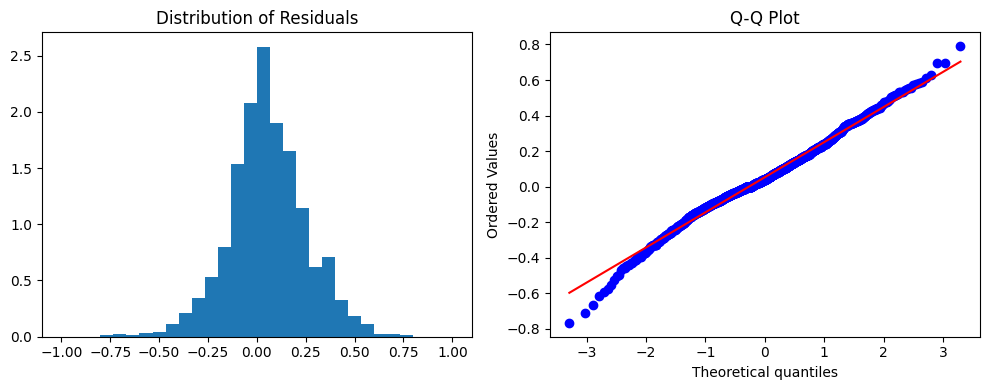

ShapiroResult(statistic=0.9916509457919356, pvalue=4.7551988298556567e-07)


In [12]:
import matplotlib.pyplot as plt
import scipy.stats as stats

def plot_qq(residuals):
   fig = plt.figure(figsize=(10, 4))
   
   # Left plot: Histogram of residuals
   plt.subplot(121)
   plt.hist(residuals, bins=30, density=True, range=[-1,1])
   plt.title('Distribution of Residuals')
   
   # Right plot: Q-Q plot
   plt.subplot(122)
   stats.probplot(residuals, dist="norm", plot=plt)
   plt.title('Q-Q Plot')
   
   plt.tight_layout()
   plt.show()

# Usage:
plot_qq(residuals)
print(stats.shapiro(residuals))

In [13]:
worst_overdone = np.absolute(residuals).argsort()[-25:]

In [14]:
list(zip(test_set.select(worst_overdone)['sentence1'], test_set.select(worst_overdone)['sentence2'], test_scores[worst_overdone], test_preds[worst_overdone]))

[('Sunderland 2-2 Bolton: Davies double gets Trotters a point but they stay in bottom three',
  'Sunderland 2-2 Bolton: Davies in at the double',
  tensor(0.8000),
  tensor(0.2760, device='cuda:0', grad_fn=<UnbindBackward0>)),
 ('Jaguar to create 1,100 jobs in UK',
  'Royal Mail to create 1,000 jobs',
  tensor(0.2500),
  tensor(0.7817, device='cuda:0', grad_fn=<UnbindBackward0>)),
 ('You just have to base your answer on what you do know, which is what you want.',
  'It is his job to see that you have what you need to do your job.',
  tensor(0.),
  tensor(0.5332, device='cuda:0', grad_fn=<UnbindBackward0>)),
 ('Most powerful typhoon of 2013 hits the Philippines',
  '23 Missing as Typhoon Utor Hits Philippines',
  tensor(0.4400),
  tensor(0.9740, device='cuda:0', grad_fn=<UnbindBackward0>)),
 ('Navistar shares were down 44 cents, or 1.1 percent, at $41.19 on the New York Stock Exchange after falling as low as $39.93.',
  'Navistar shares rose a penny to $41.64 at late afternoon on the Ne